In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Add necessary imports
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import copy
import numpy as np
from tqdm import tqdm

In [3]:
# Set our torch seed for perfect reproducibility
torch.manual_seed(37718)

# Download and setup FashionMNIST Dataset

In [4]:
# this transform will convert data to tensor then standardize the data (precomputed mean and std)
train_transform = transforms.Compose([
    # transforms.RandomRotation(degrees=20),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.1, 0.1),  # Random shifts up to 10%
        scale=(0.9, 1.1),      # Random scaling +/- 10%
    ),
    # transforms.RandomCrop(28, padding=4),  # Random crops with padding
    transforms.RandomHorizontalFlip(),     # Random horizontal flips
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
    transforms.RandomErasing(p=0.2)  # Randomly erase parts of the image
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# download training and testing and apply transform to both
training_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
testing_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

In [5]:
# Create data loaders with better batch sizes and workers for performance
batch_size = 128
trainloader = torch.utils.data.DataLoader(
    training_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True
)
testloader = torch.utils.data.DataLoader(
    testing_data, 
    batch_size=batch_size*2, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True
)

# WideResNet Model Implementation

In [6]:
class BasicBlock(nn.Module):
    """Basic building block for WideResNet"""
    def __init__(self, in_planes, out_planes, stride, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        # Batch normalization and first convolution
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # Batch normalization and second convolution
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Dropout and skip connection
        self.dropout_rate = dropout_rate
        self.equalInOut = (in_planes == out_planes)
        
        # Skip connection - either identity or 1x1 conv to match dimensions
        self.shortcut = nn.Sequential()
        if not self.equalInOut:
            self.shortcut = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
    
    def forward(self, x):
        # First part of residual function
        out = F.relu(self.bn1(x))
        
        # For skip connections, prepare the input
        residual = out if self.equalInOut else x
        
        # Main path with convolutions
        out = self.conv1(out)
        out = F.relu(self.bn2(out))
        
        # Apply dropout if specified
        if self.dropout_rate > 0:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
            
        out = self.conv2(out)
        
        # Add residual connection
        out += self.shortcut(residual)
        
        return out

In [7]:
class WideResNet(nn.Module):
    """WideResNet model with customizable depth and width"""
    def __init__(self, depth=16, width_factor=8, dropout_rate=0.3, num_classes=10):
        super(WideResNet, self).__init__()
        
        # Determine number of blocks per stage
        assert (depth - 4) % 6 == 0, "Depth must be 6n+4"
        n = (depth - 4) // 6
        
        # Define number of channels at each stage
        channels = [16, 16*width_factor, 32*width_factor, 64*width_factor]
        
        # Initial convolution
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        
        # Create blocks for each stage
        self.stage1 = self._make_layer(n, channels[0], channels[1], stride=1, dropout_rate=dropout_rate)
        self.stage2 = self._make_layer(n, channels[1], channels[2], stride=2, dropout_rate=dropout_rate)
        self.stage3 = self._make_layer(n, channels[2], channels[3], stride=2, dropout_rate=dropout_rate)
        
        # Final batch norm, pooling and classifier
        self.bn = nn.BatchNorm2d(channels[3])
        self.fc = nn.Linear(channels[3], num_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def _make_layer(self, blocks, in_planes, out_planes, stride, dropout_rate):
        layers = []
        # First block might change dimensions
        layers.append(BasicBlock(in_planes, out_planes, stride, dropout_rate))
        
        # Remaining blocks keep the same dimensions
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_planes, out_planes, 1, dropout_rate))
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                m.bias.data.zero_()
                
    def forward(self, x):
        # Initial convolution
        out = self.conv1(x)
        
        # Pass through stages
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        
        # Final batch norm and ReLU
        out = F.relu(self.bn(out))
        
        # Global average pooling
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        
        # Classifier
        out = self.fc(out)
        
        return out

# Model Training with Best Model Checkpointing

In [8]:
def train_model_with_checkpoints(model, trainloader, testloader, epochs=30, lr=0.01):
    """Train model with checkpoint saving for the best performance"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4, nesterov=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    # For tracking metrics
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_accs = []
    test_accs = []
    
    print(f"Training on {device}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Use tqdm for a nice progress bar
        train_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                "loss": f"{loss.item():.4f}", 
                "acc": f"{100.0 * correct / total:.2f}%"
            })
        
        # Calculate training accuracy
        train_acc = 100 * correct / total
        train_accs.append(train_acc)
        
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        
        test_pbar = tqdm(testloader, desc=f"Epoch {epoch+1}/{epochs} [Test]")
        
        with torch.no_grad():
            for images, labels in test_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                test_pbar.set_postfix({
                    "acc": f"{100.0 * correct / total:.2f}%"
                })
        
        # Calculate test accuracy
        test_acc = 100 * correct / total
        test_accs.append(test_acc)
        
        # Update learning rate based on validation performance
        scheduler.step(test_acc)
        
        # Print statistics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test Acc: {test_acc:.2f}%")
        
        # Check if this is the best model and save checkpoint
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_acc,
            }, 'wrn_fashion_best.pth')
            print(f"  New best accuracy: {best_acc:.2f}% - Saved checkpoint!")
    
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    print(f"Training complete. Best accuracy: {best_acc:.2f}%")
    
    return model, train_accs, test_accs, best_acc

In [9]:
def plot_training_results(train_accs, test_accs):
    """Plot training and testing accuracy over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(test_accs, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('wrn_training_results.png')
    plt.show()

# Create and Train the Model

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
np.random.seed(42)

# Create a smaller version of WideResNet (reduced depth and width for faster training)
model = WideResNet(depth=4, width_factor=4, dropout_rate=0.3, num_classes=10)
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

Model has 8,948,922 parameters


In [11]:
# Train the model
trained_model, train_accs, test_accs, best_acc = train_model_with_checkpoints(
    model, trainloader, testloader, epochs=1, lr=0.01
)

/home/querylake_manager/miniconda3/envs/QL_1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on cuda


Epoch 1/1 [Test]: 100%|██████████| 40/40 [00:00<00:00, 72.30it/s, acc=69.93%]


Epoch 1/1
  Train Loss: 1.3152, Train Acc: 52.58%
  Test Acc: 69.93%
  New best accuracy: 69.93% - Saved checkpoint!
Training complete. Best accuracy: 69.93%


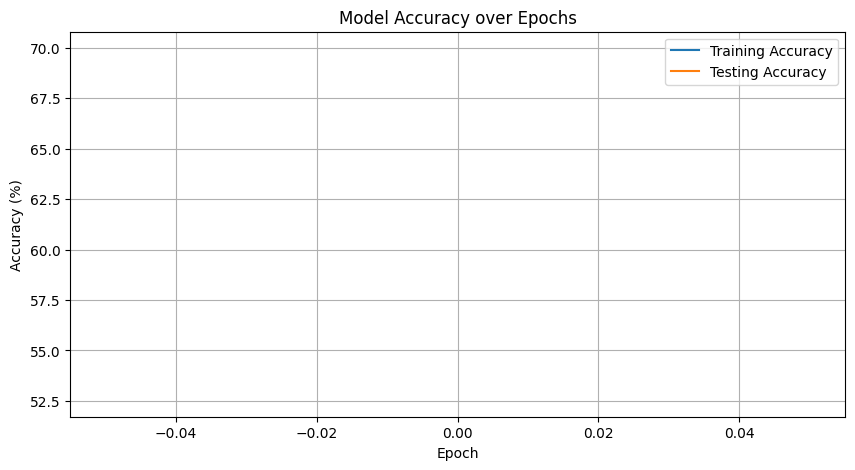

In [12]:
# Plot results
plot_training_results(train_accs, test_accs)

In [30]:
def evaluate_best_model(model_path, test_loader):
    """Load the best model and evaluate it on the test set"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a clean model instance
    model = WideResNet(depth=40, width_factor=4, dropout_rate=0.0, num_classes=10)
    
    # Load the saved model weights
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Evaluate
    correct = 0
    total = 0
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Final Test Accuracy: {accuracy:.2f}%")
    return all_preds, accuracy

# Evaluate the best model
# Uncomment to run
predictions, final_acc = evaluate_best_model('wrn_fashion_best_overnight.pth', testloader)

/tmp/ipykernel_311017/657403414.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Final Test Accuracy: 95.70%


In [31]:
# Save predictions for submission
import json

submission_data = {"name": "Kyle McCleary", "predictions": [int(x) for x in predictions]}
with open("submission.json", "w") as f:
	json.dump(submission_data, f)

In [32]:
# Save trained model
torch.save(trained_model.state_dict(), "wrn_model.pth")

In [ ]:
# import requests
# # Send results - comment out if not needed

# data = {
#     "name": "I copied this from Kyle McCleary",
#     "predictions": predictions.tolist() if isinstance(predictions, np.ndarray) else predictions
# }
# response = requests.post("https://csc7700leaderboard-d4fce9d9h2b5h8ab.centralus-01.azurewebsites.net/submit", json=data)
# response.raise_for_status()
# print(response.json())


{'message': 'Submission received. Accuracy: 95.70%'}
